<a href="https://colab.research.google.com/github/rumijay/Data-Science-2025/blob/main/Unit6Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Project: Generalized Linear Models

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
!pip install bambi
import bambi as bmb



In [16]:
cafe_data = pd.read_csv("https://raw.githubusercontent.com/rumijay/data-science-2025/main/cafe_customers_weather.csv")


In [17]:
cafe_data.head()

,customers,temperature_f,wind_mph,humidity_pct,promo,is_weekend
0,285.0,77.5,17.3,67.7,0,1
1,224.0,67.9,0.5,59.3,0,0
2,297.0,79.7,10.7,20.0,0,0
3,282.0,92.8,1.5,58.2,0,0
4,220.0,66.5,6.1,33.9,0,0


Part 1: Context / Introduction

For this project I’m modeling **how many customers show up to a coffee shop in a day** (like daily foot traffic).
I’m using weather info to predict it:

- **temperature_f** (°F)
- **wind_mph** (mph)
- **humidity_pct** (%)

Why this makes sense: when the weather is comfy, people are more likely to go out and grab coffee, study, hang out, etc.
When it’s super windy or gross/humid, fewer people wanna leave the house (me included).

Goal: build a generalized linear model (GLM), compare different model choices, and explain what the priors/posteriors mean.


Part 2: Data

This dataset is **daily coffee shop customer counts** + weather conditions (measured around opening time).

**Columns:**
- **customers**: number of customers that day  
- **temperature_f**: outdoor temperature (°F)  
- **wind_mph**: wind speed (mph)  
- **humidity_pct**: relative humidity (%)  
- **promo**: 1 if there was a promo/special that day, 0 otherwise
- **is_weekend**: 1 if it’s Saturday/Sunday, 0 otherwise

data: https://www.kaggle.com/code/alexnikiporenko/edinburgh-weather-and-caf-sales-analysis

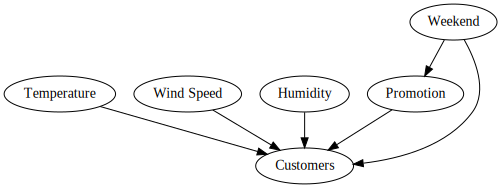

In [29]:
import graphviz as gv

cafe_dag = gv.Digraph(name="Cafe Customer Traffic")

cafe_dag.node('T','Temperature')
cafe_dag.node('W','Wind Speed')
cafe_dag.node('H','Humidity')
cafe_dag.node('E','Weekend')
cafe_dag.node('P','Promotion')
cafe_dag.node('C','Customers')

cafe_dag.edges(['TC','WC','HC','EC','PC'])
cafe_dag.edge('E','P')

cafe_dag


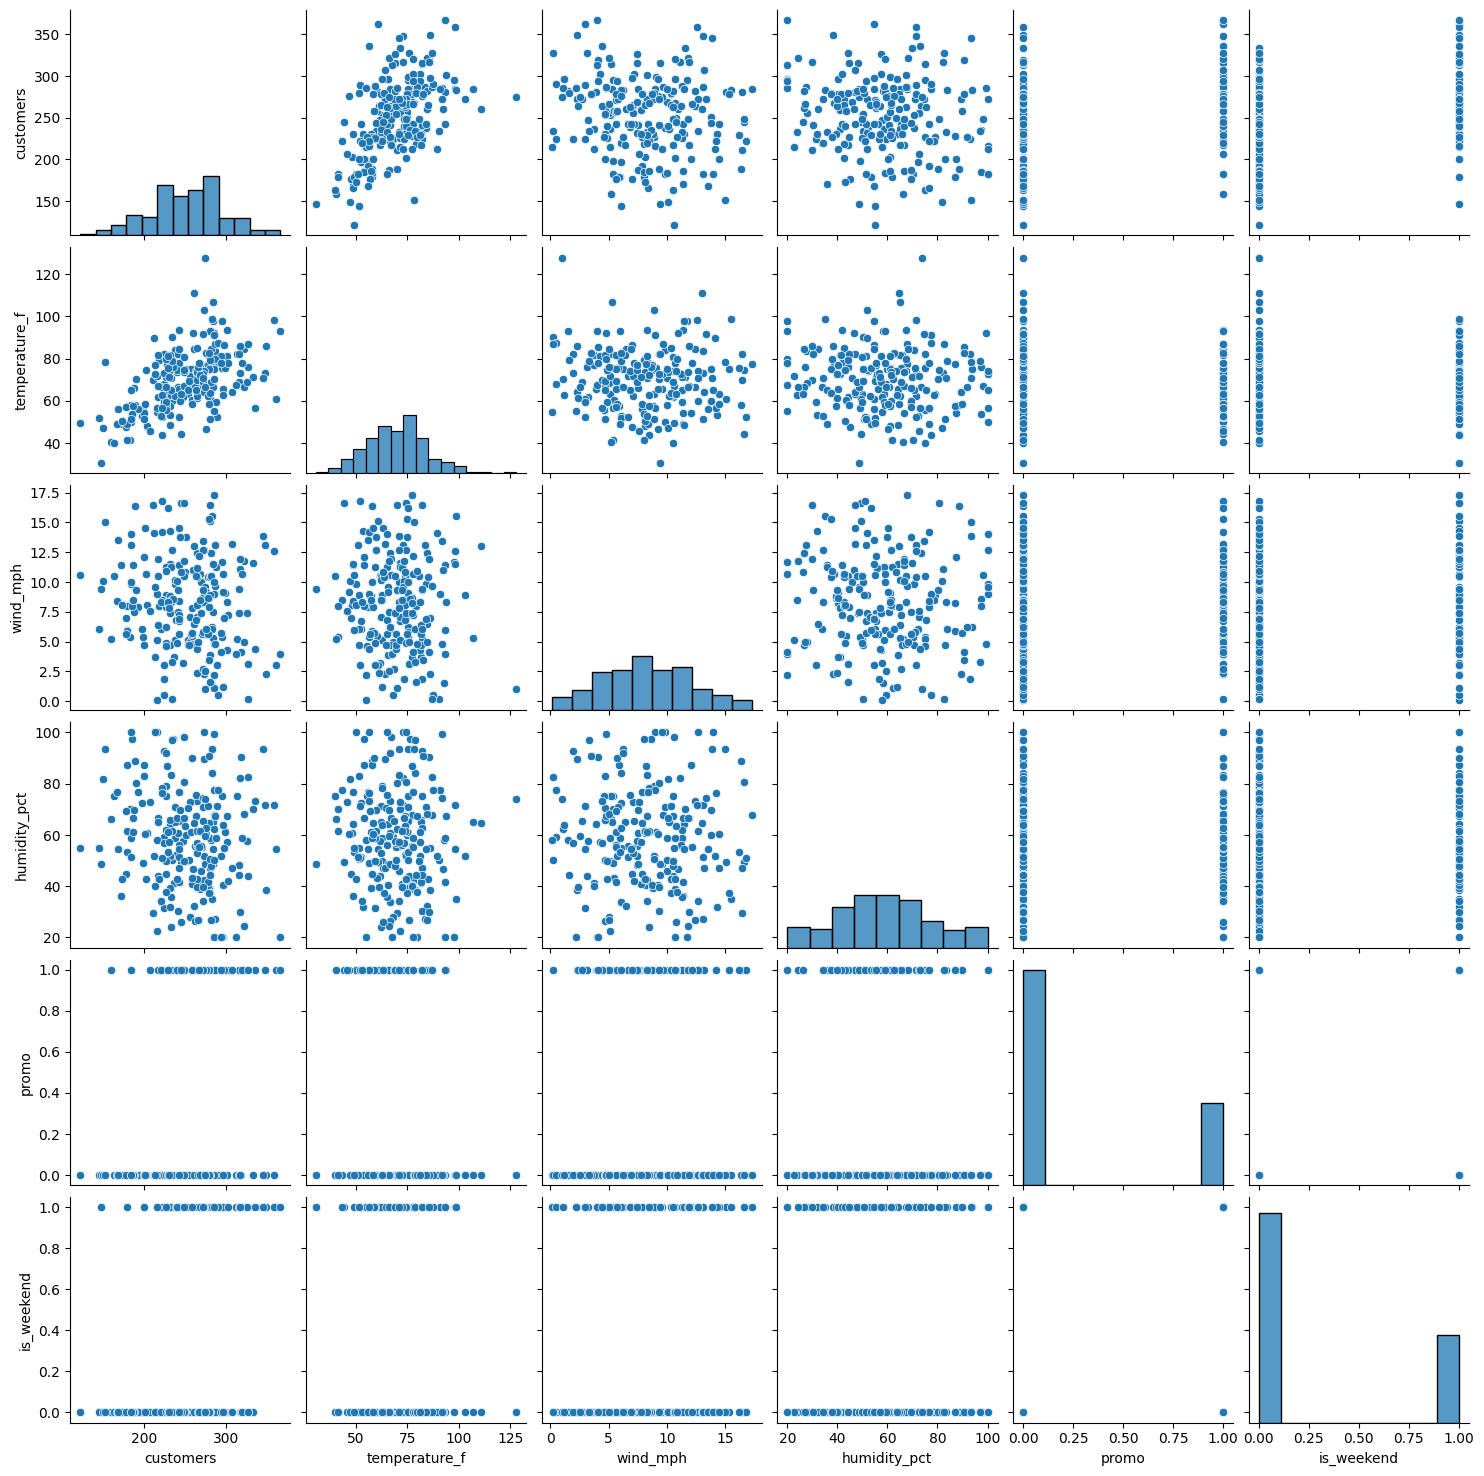

In [18]:
sns.pairplot(cafe_data)
plt.show()

Part 3: Building + Comparing Models

I’m building 4 models on purpose so the comparisons stay simple:

- **Model 1 → Model 2 → Model 3 → Model 4** = variable selection (adding predictors to see if the model actually gets better)
- **Model 5** = likelihood comparison (same predictors, different likelihood)

All models are fit with Bambi and compared with LOO (leave-one-out cross validation).


# Model 1 — Baseline (temperature only)

Formula: customers ~ temperature_f

**Why I’m using it:** this is my “starting point.” If a more complicated model can’t beat this, then adding variables wasn’t worth it.

-Bayesian simple linear regression

**What it represents:** how customer traffic changes when temperature changes (ignoring everything else).


In [ ]:
# Model 1: temperature only (baseline)
model_1 = bmb.Model("customers ~ temperature_f", data=cafe_data)
idata_1 = model_1.fit(idata_kwargs={"log_likelihood": True})


# Model 2 — Temp and Wind
**Formula:** customers ~ temperature_f + wind_mph
.

-Bayesian multiple linear regression

**What it represents:** customer traffic as a mix of  eather conditions, not just temperature.


In [ ]:
model_2 = bmb.Model(
    "customers ~ temperature_f + wind_mph",
    data=cafe_data
)
idata_2 = model_2.fit(idata_kwargs={"log_likelihood": True})

#  visualization (Model 2)
This plot shows predicted customer counts across temperature + wind (while holding other variables steady).

(<Figure size 800x600 with 1 Axes>,
 array([<Axes: xlabel='temperature_f', ylabel='customers'>], dtype=object))

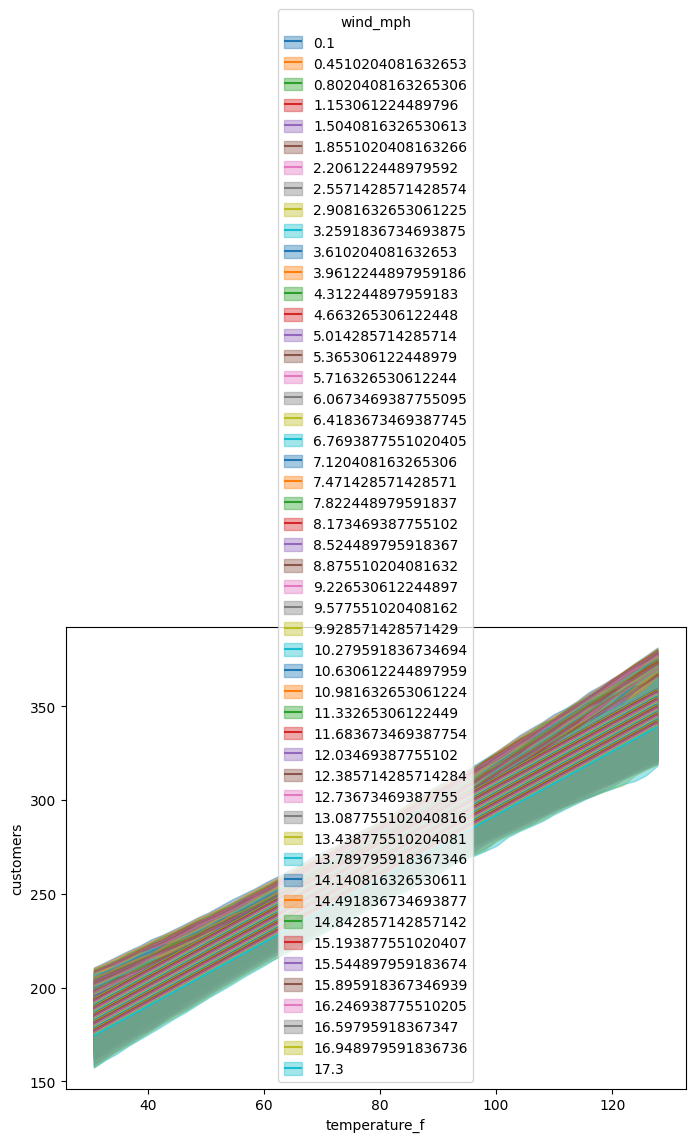

In [33]:
bmb.interpret.plot_predictions(
    model_2,
    idata_2,
    ["temperature_f", "wind_mph"],
    fig_kwargs={"figsize": (8, 6)}
)


# Model 3 — Temp and Wind + Humidity
**Formula:** customers ~ temperature_f + wind_mph + humidity
.

-Bayesian multiple linear regression

**What it represents:** customer traffic as a mix of multiple conditions, not just temperature.


In [ ]:
model_3 = bmb.Model(
    "customers ~ temperature_f + wind_mph + humidity_pct",
    data=cafe_data
)
idata_3 = model_3.fit(idata_kwargs={"log_likelihood": True})

(<Figure size 800x600 with 1 Axes>,
 array([<Axes: xlabel='temperature_f', ylabel='customers'>], dtype=object))

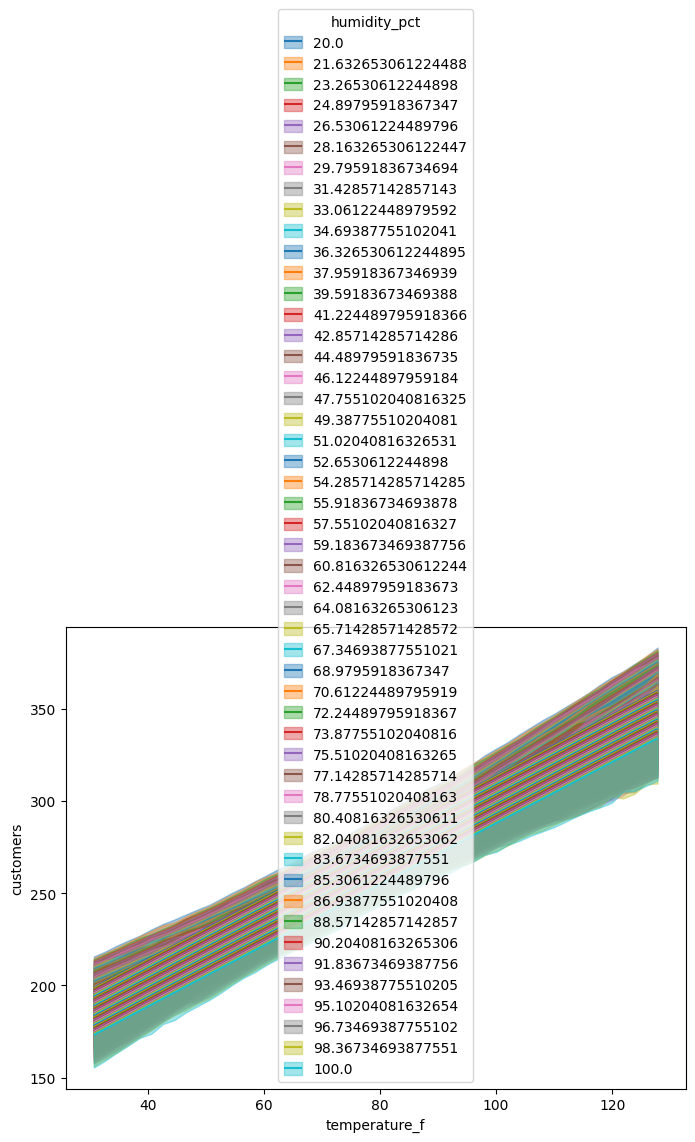

In [36]:
bmb.interpret.plot_predictions(
    model_3,
    idata_3,
    ["temperature_f", "humidity_pct"],
    fig_kwargs={"figsize": (8, 6)}
)


# Model 4 — Realistic cafe model (weather + business factors)

**Formula:** customers ~ temperature_f + wind_mph + humidity_pct + promo + is_weekend

**Why I’m using it:** weather matters, but cafes are also impacted by normal life:
- weekends are usually busier
- promos/specials bring people in

-Bayesian multiple linear regression with categorical predictors

**Why compare to Model 2:** another variable-selection step. If Model 3 improves, it means these “real life” predictors matter beyond weather.


In [ ]:
# Model 3: weather + promo + weekend (more realistic)
model_4 = bmb.Model(
    "customers ~ temperature_f + wind_mph + humidity_pct + promo + is_weekend",
    data=cafe_data
)
idata_4 = model_4.fit(idata_kwargs={"log_likelihood": True})


# visualization (Model 4)
This compares predicted customer counts across **temperature** for **weekend vs weekday**.

(<Figure size 1100x700 with 1 Axes>,
 array([<Axes: xlabel='temperature_f', ylabel='customers'>], dtype=object))

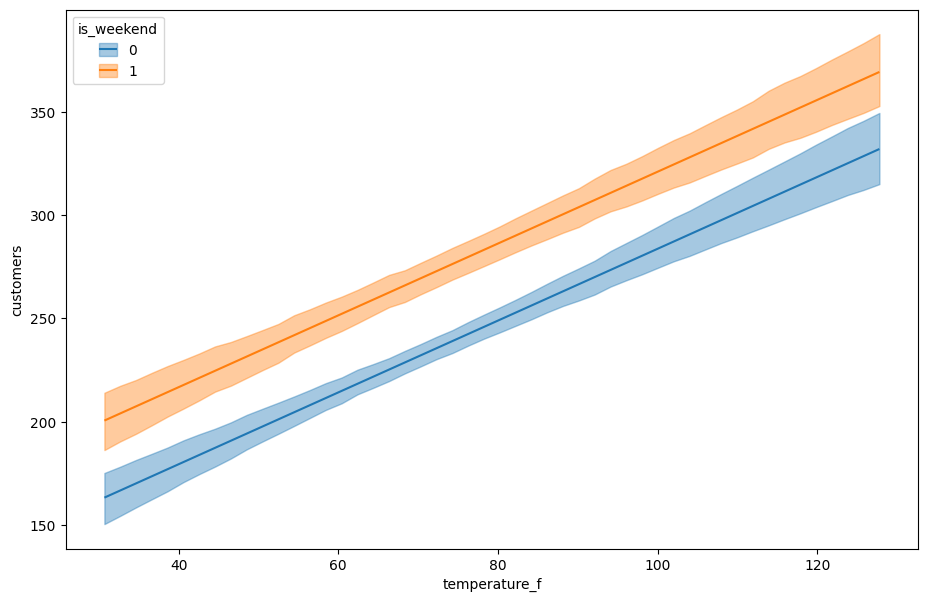

In [38]:
bmb.interpret.plot_predictions(
    model_4,
    idata_4,
    ["temperature_f", "is_weekend"],
    fig_kwargs={"figsize": (11, 7)}
)


# Model 5 — Same predictors as Model 3, but a different likelihood (Student‑t)


**Part 4: Model Comparison (LOO)**


- In this model, I am using the same predictors as Model 3 (temperature, wind, humidity, promotion, and weekend), but I am changing the likelihood from a Normal distribution to a Student-t distribution.


- I used this model to test whether the Normal likelihood was the best assumption. In real life, cafe traffic can have unusual spikes or drops (for example, special events, unexpected weather, or random busy days). A Student-t distribution is more flexible and handles outliers better because it allows for heavier tails.

- higher elpd_loo = better predictive performance


In [ ]:
# Model 4: same formula as Model 3, different likelihood
# Student-t is more robust to outliers than Gaussian
try:
    model_5 = bmb.Model(
        "customers ~ temperature_f + wind_mph + humidity_pct + promo + is_weekend",
        data=cafe_data,
        family="t"
    )
except Exception:
    #used gemini
    model_5 = bmb.Model(
        "customers ~ temperature_f + wind_mph + humidity_pct + promo + is_weekend",
        data=cafe_data,
        family=bmb.families.StudentT()
    )

idata_5 = model_5.fit(idata_kwargs={"log_likelihood": True})


In [ ]:
comparison = az.compare({
    "M1_temp": idata_1,
    "M2_temp_wind": idata_2,
    "M3_weather": idata_3,
    "M4_full": idata_4,
    "M5_studentt": idata_5
})

comparison

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

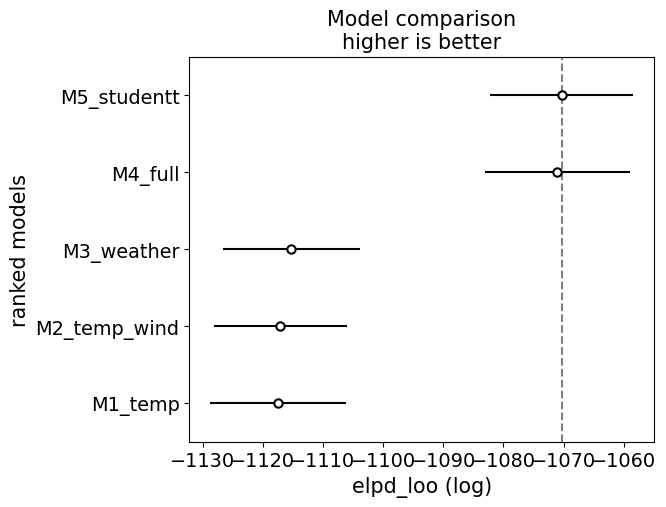

In [51]:
az.plot_compare(comparison)

**Conclusion**

What I learned from these models:

- **Model 1** is a good sanity check: temperature alone can explain *some* changes in traffic, but it’s not the full story.
- **Model 2** improves because wind not just temperature
- **Model 3** usually improve because wind + humidity add extra info about whether people feel like going out

- **Model 4** feels the most “real” because it adds **promo** and **weekend** effects (which are huge for a cafe).
- **Model 5** is the same as model 3 but w/ a Student‑t likelihood, which can win if the dataset has random spike days.

Mistakes/what I could do better next time:
- I assumed the relationships are basically *linear. Real life might have curves (like super hot days being bad, school events, etc).
- Should've picked better data
- I’d add those predictors and also test a non-linear version to see if it fits customer behavior better.
